# Time Series Analysis
The purpose of this notebook is to explore the time series trends of the different renewable energy sources contained in the Spanish energy market dataset.
I first explore the trends and then build and test forecasting models

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from src.data.make_dataset import *
from IPython.display import Image
from src.stattests import *
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['axes.titlesize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['legend.fontsize'] = 'large'
matplotlib.rcParams['lines.linewidth'] = 2


In [2]:
energy_df = pd.read_csv('data/raw/energy_dataset.csv')  # Read in datasets
weather_df = pd.read_csv('data/raw/weather_features.csv')

In [9]:
energy_df = resample_dataframe(
    datetime_conversion(
        drop_absent_cols(energy_df)))

dropping column:  generation fossil coal-derived gas
dropping column:  generation fossil oil shale
dropping column:  generation fossil peat
dropping column:  generation geothermal
dropping column:  generation hydro pumped storage aggregated
dropping column:  generation marine
dropping column:  generation wind offshore
dropping column:  forecast wind offshore eday ahead


Text(0, 0.5, 'Power Generation (MW)')

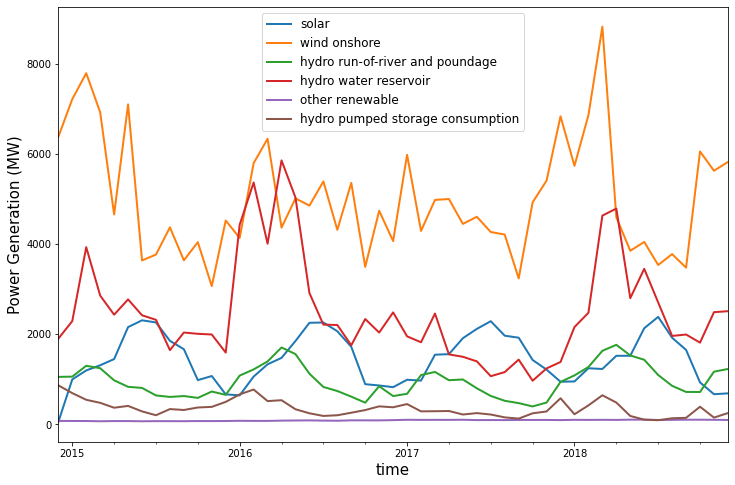

In [10]:
renewable_sources = ['solar', 'wind onshore', 'hydro run-of-river and poundage', 'hydro water reservoir', 'other renewable', 'hydro pumped storage consumption']
renewable_cols = ['generation ' + source for source in renewable_sources]
fossil_fuel_sources = ['fossil brown coal/lignite', 'fossil gas', 'fossil hard coal', 'fossil oil']
fossil_fuel_cols = ['generation ' + source for source in fossil_fuel_sources]
other_source = ['nuclear', 'other', 'waste', 'biomass']
other_cols = ['generation ' + source for source in other_source]

fig,ax = plt.subplots(figsize = (12,8))
for i, col in enumerate(renewable_cols):
     energy_df[col].resample('1m').median().plot(ax=ax, label = renewable_sources[i])
ax.legend()
ax.set_ylabel('Power Generation (MW)')

## Are the time series stationary? Is there an overall trend?

The augmented dicky fuller (adf) test, tests for a unit root, and, while it cannot tell if the data is seasonal (in the case of this dataset), it can determine if there is a growing or decreasing trend in time. In all the power sources, the adf demonstrates that there is no overall increase or decrease in the series.

In [11]:
for i, col in enumerate(renewable_cols):
     adf_test(energy_df[col], renewable_sources[i])


Results of Dickey-Fuller Test for solar:
Test Statistic                   -5.018076
p-value                           0.000020
#Lags Used                       20.000000
Number of Observations Used    1441.000000
Critical Value (1%)              -3.434896
Critical Value (5%)              -2.863548
Critical Value (10%)             -2.567839
dtype: float64
Reject Null Hypothesis, Series is Stationary


Results of Dickey-Fuller Test for wind onshore:
Test Statistic                -1.256938e+01
p-value                        2.019879e-23
#Lags Used                     5.000000e+00
Number of Observations Used    1.456000e+03
Critical Value (1%)           -3.434849e+00
Critical Value (5%)           -2.863527e+00
Critical Value (10%)          -2.567828e+00
dtype: float64
Reject Null Hypothesis, Series is Stationary


Results of Dickey-Fuller Test for hydro run-of-river and poundage:
Test Statistic                   -3.375681
p-value                           0.011816
#Lags Used               

## Seasonal Decomposition

It can be useful to decompose time series into their respective components: overall trend, seasonal data and residual. Given that the DF tests performed showed that the time series are indeed stationary, we expect that the overall trend does not show an obvious growth or decay.

Results of D’Agostino and Pearson Test for generation solar:
p = 0.846122
null hyp: series comes from a normal distribution
The null hypothesis cannot be rejected
Results of D’Agostino and Pearson Test for generation wind onshore:
p = 0.544397
null hyp: series comes from a normal distribution
The null hypothesis cannot be rejected
Results of D’Agostino and Pearson Test for generation hydro run-of-river and poundage:
p = 0.633413
null hyp: series comes from a normal distribution
The null hypothesis cannot be rejected
Results of D’Agostino and Pearson Test for generation hydro water reservoir:
p = 0.146521
null hyp: series comes from a normal distribution
The null hypothesis cannot be rejected


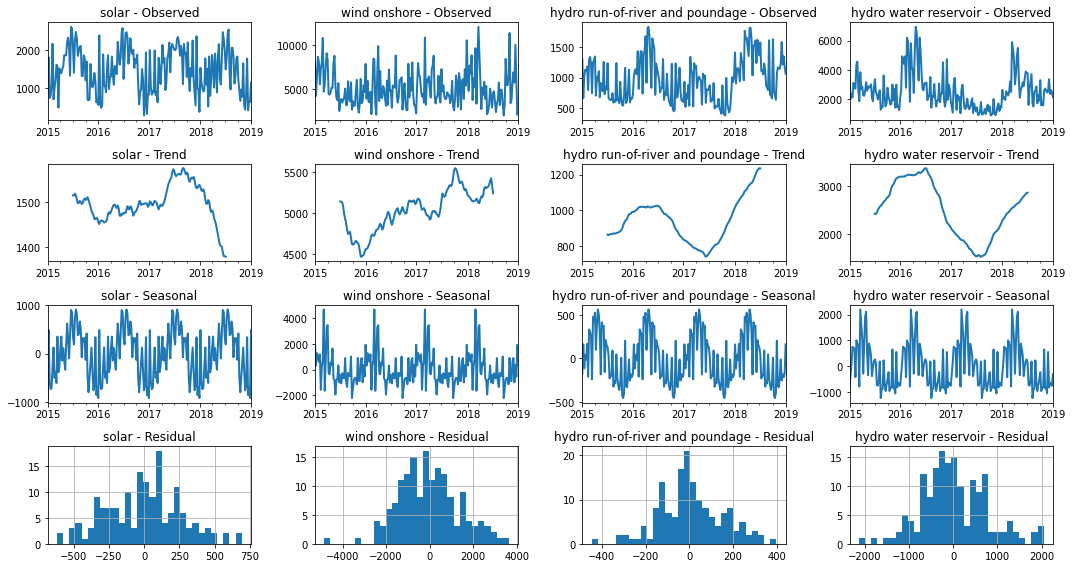

In [12]:
important_renewable_sources = renewable_cols[:4]

# Create dictionary for the period of seasonal decomposition given resample rate
time_dict = {'1d':365, '1w':52, '2w':26, '1m':12}  
def time_series_decomposition(resample_rate='1m'):  # Choose the frequency of the resample
    fig,ax = plt.subplots(4, 4, figsize=(15, 8))
    for i, source in enumerate(important_renewable_sources):
        # print(source)
        result = seasonal_decompose(energy_df[source].resample(resample_rate).median(), period = time_dict[resample_rate])
        result.observed.plot(ax=ax[0,i])
        ax[0,i].set_title(renewable_sources[i] + ' - Observed')
        result.trend.plot(ax=ax[1,i])
        ax[1,i].set_title(renewable_sources[i] + ' - Trend')
        result.seasonal.plot(ax=ax[2,i])
        ax[2,i].set_title(renewable_sources[i] + ' - Seasonal')
        result.resid.hist(ax=ax[3,i], bins=30)
        ax[3,i].set_title(renewable_sources[i] + ' - Residual')
        for j in range(4):
            ax[j,i].set_xlabel('')
        normal_test(result.resid, important_renewable_sources[i])
    fig.tight_layout()

time_series_decomposition('1w')  # Changing the resampling rate can help to discern different trends


For the seasonal decomposition to work we expect that the residual is normally distributed, a D’Agostino and Pearson normal test i sapplied on the residuals to test how well they conform to a normal distribution.

As shown below, once seasonal differences are accounted for, the trends are stationary

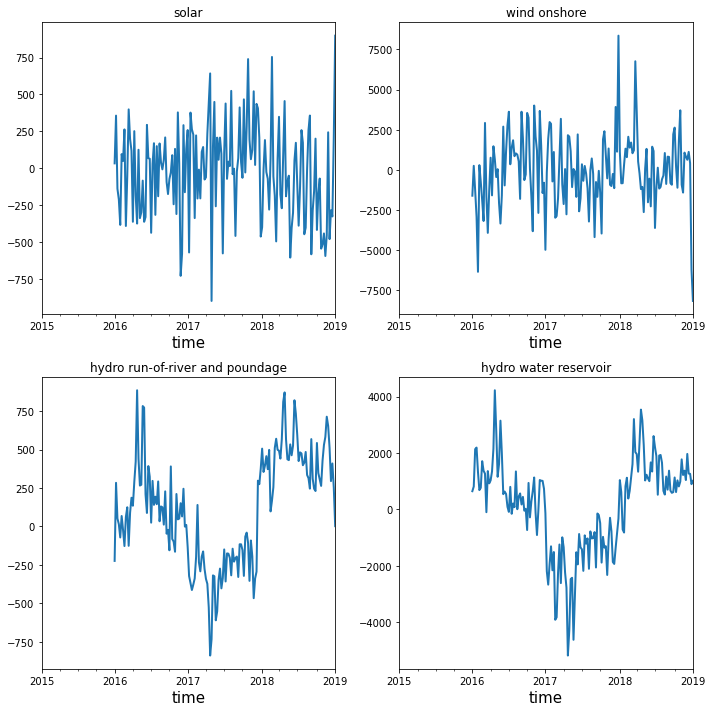

In [13]:
def seasonal_difference_plot(timeseries, ax):
    series = timeseries - timeseries.shift(365)
    series.resample('1w').mean().plot(ax=ax)
    return series
fig, ax = plt.subplots(2, 2, figsize=(10,10))
axs = ax.ravel()

for i, source in enumerate(important_renewable_sources):
    energy_df['seasonal difference - ' +renewable_sources[i]] = seasonal_difference_plot(energy_df[source], axs[i])
    axs[i].set_title(renewable_sources[i])
fig.tight_layout()

## Time Series Forecasting with Linear Regression Models
I now implement and test different linear regression models on the dataset. While these may be too simple to capture the patterns, they may provide more interpretability than more complex models (RNNs, LSTMs etc.)

For the first example I will use SARIMA model on the data to forecast the results


### AR - Autoregression
\begin{equation}
y_i = c + \sum_{i=1}^{p}\varphi_i y_{t-1} + \varepsilon_t

\end{equation}

 - The simplest AR model assumes each step in the series is correlated with previous timesteps.
 - An autocorrelation plot will help to uncover this trend

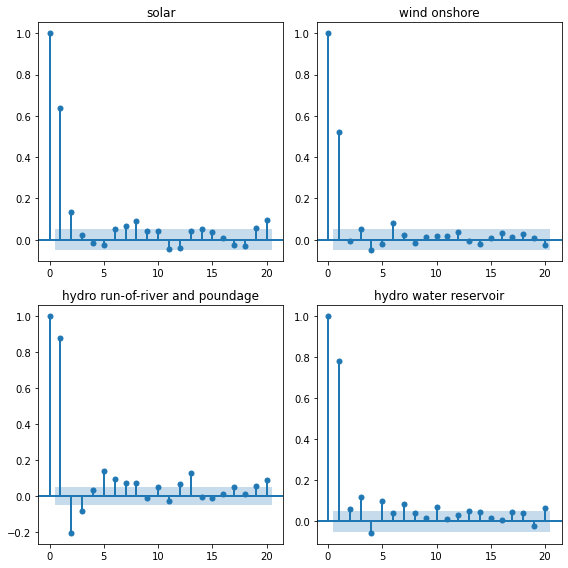

In [16]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
axs = ax.ravel()
for i, source in enumerate(important_renewable_sources):
    plot_pacf(energy_df[important_renewable_sources[i]], lags=20, ax=axs[i])
    axs[i].set_title(renewable_sources[i])
fig.tight_layout()

For the AR model, the p value, or the autoregression lag, is chosen at the point that the pacf shuts off, which are given by:
- solar: AR(2)
- wind onshore: AR(1)
- run-of-river poundage: AR(2)
- water reservoir: AR(1)

This "shut-off point" tells us how may terms in the autoregression model need to be included to accurately desribe the pattern
 

### MA - Moving Average 

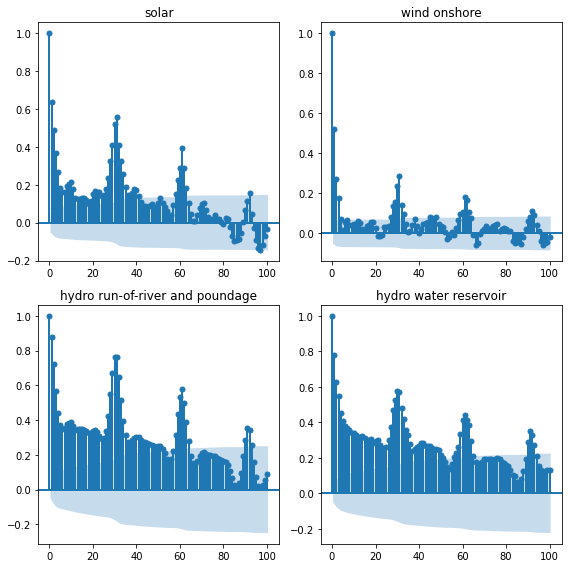

In [18]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
axs = ax.ravel()
for i, source in enumerate(important_renewable_sources):
    plot_acf(energy_df[important_renewable_sources[i]], lags=100, ax=axs[i])
    axs[i].set_title(renewable_sources[i])
fig.tight_layout()

Only onshore wind shows that a moving average term should be inlcuded hence I will choose the follwing SARIMA models:
- solar: SARIMA(2,0,0)(0,0,0,365)
- wind onshore: SARIMA(1,0,0)(0,0,0,365)
- run-of-river poundage: ASARIMA(2,0,0)(0,0,0,365)
- water reservoir: SARIMA(1,0,0)(0,0,0,365)

In [30]:
SARIMA_order_dict = {'solar':((2, 0, 0), (2, 0, 0, 365)),
                 'wind onshore':((1, 0, 0), (1, 0, 0, 365)), 
                 'hydro run-of-river and poundage':((2, 0, 0), (2, 0, 0, 365)),
                 'hydro water reservoir':((1, 0, 0), (1, 0, 0, 365))}

# Implement SARIMAX model, we set the seasnal period to be 365 and use an S(365)AR(i) model
fig, ax = plt.subplots(2, 2, figsize=(10,10))
axs = ax.ravel()
for i, source in enumerate(important_renewable_sources):
    model = SARIMAX(energy_df[important_renewable_sources[i]], 
                  order=SARIMA_order_dict[renewable_sources[i]][0],
                  seasonal_order=SARIMA_order_dict[renewable_sources[i]][1],
                  freq='d')
    model_fit = model.fit()
    energy_df['forecast']=model_fit.predict(start=365, end=1200, dynamic=True)
    energy_df[[important_renewable_sources[i],'forecast']].iloc[300:400].plot(ax=axs[i])
    # print(renewable_sources[i])
    # print(model_fit.summary())

In [26]:
model_fit.predict(start=100, end=200, dynamic=True)

time
2015-04-10 00:00:00+00:00    1499.249096
2015-04-11 00:00:00+00:00    1422.287654
2015-04-12 00:00:00+00:00    1349.276899
2015-04-13 00:00:00+00:00    1280.014029
2015-04-14 00:00:00+00:00    1214.306653
                                ...     
2015-07-15 00:00:00+00:00       9.523217
2015-07-16 00:00:00+00:00       9.034359
2015-07-17 00:00:00+00:00       8.570595
2015-07-18 00:00:00+00:00       8.130638
2015-07-19 00:00:00+00:00       7.713265
Freq: D, Name: predicted_mean, Length: 101, dtype: float64

In [79]:
energy_df['seasonal difference - ' + renewable_sources[1]].index

DatetimeIndex(['2014-12-31 23:00:00+00:00', '2015-01-01 00:00:00+00:00',
               '2015-01-01 01:00:00+00:00', '2015-01-01 02:00:00+00:00',
               '2015-01-01 03:00:00+00:00', '2015-01-01 04:00:00+00:00',
               '2015-01-01 05:00:00+00:00', '2015-01-01 06:00:00+00:00',
               '2015-01-01 07:00:00+00:00', '2015-01-01 08:00:00+00:00',
               ...
               '2018-12-31 13:00:00+00:00', '2018-12-31 14:00:00+00:00',
               '2018-12-31 15:00:00+00:00', '2018-12-31 16:00:00+00:00',
               '2018-12-31 17:00:00+00:00', '2018-12-31 18:00:00+00:00',
               '2018-12-31 19:00:00+00:00', '2018-12-31 20:00:00+00:00',
               '2018-12-31 21:00:00+00:00', '2018-12-31 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=35064, freq=None)